In [9]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from scipy.special import erfc

from glob import glob
import re 
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# import MLP_models as mlp 

device='mps'

outdir = '/Users/wslatton/Documents/population_geometry_opt_coding/results'
figdir = '/Users/wslatton/Documents/population_geometry_opt_coding/figures/pngs'

import os
os.makedirs(figdir,exist_ok=True)

In [19]:
outpath = outdir + '/mlp_exps_P_500000_nonlin_tanh_alpha_0.2'
res = np.load(outpath + '/eg_geom_results.npy', allow_pickle=True).item()
rand_layer_names, errs_the_rand, errs_emp_rand, geoms_rand , \
trained_layer_names, errs_the_train, errs_emp_train, geoms_train, \
val_losses, train_losses, svm_rand, svm_train, \
derrs_t, derrs_e, dgeoms, ps, dsvm = res.values() 
# epochs = np.array([e.split('.')[0] for e in epochs], dtype=int)

/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/237554475.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['b'].set_xticklabels(rand_layer_names, **tick_kwargs)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/237554475.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['c'].set_xticklabels(trained_layer_names,**tick_kwargs)


o
o
o
o
o
o
o
o


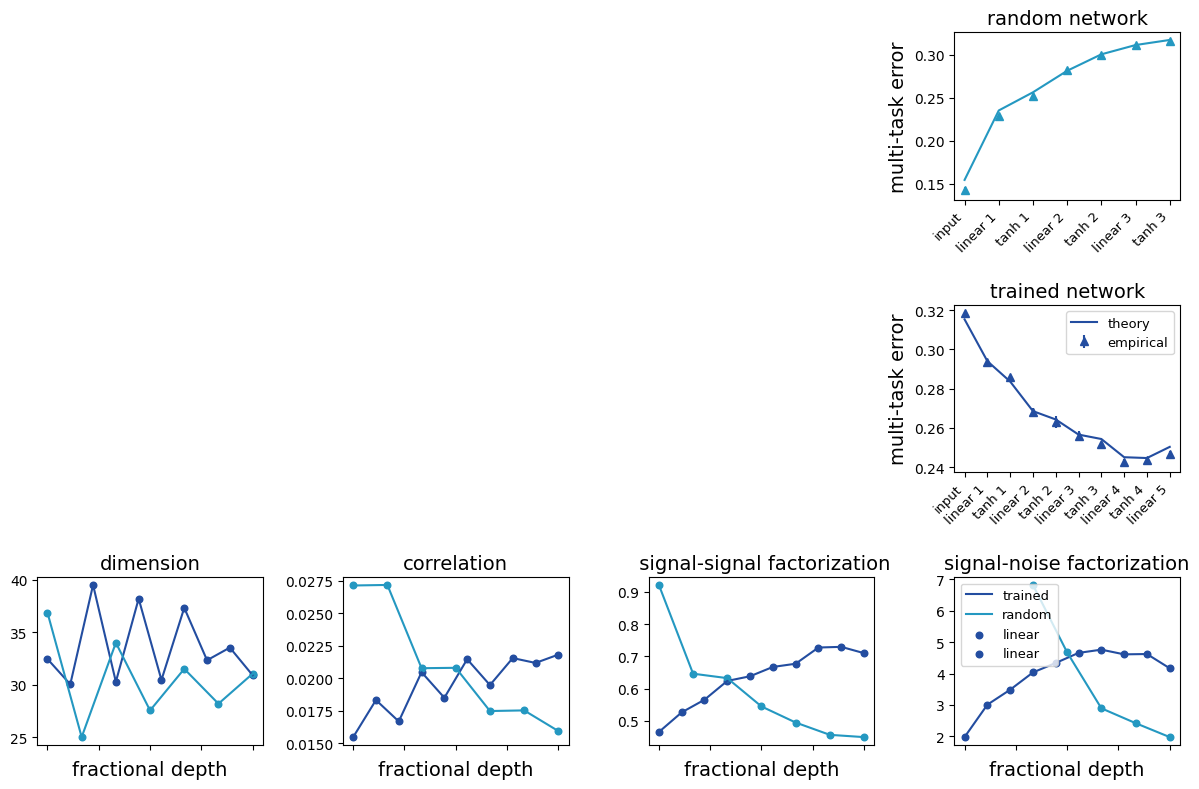

In [20]:
fig, ax = plt.subplot_mosaic([['a', 'a', 'a', 'b'],
                              ['a', 'a', 'a', 'c'],
                              ['d', 'e', 'f', 'g']],
                              # figsize=(12,8.5))
                             figsize=(12,8.))
fn = 14
tick_kwargs = {'rotation' : 45,
               'ha' : 'right', 
               'fontsize' : fn*2/3}

cmap = plt.get_cmap('YlGnBu')([0.6,0.8])
crand = cmap[0] 
ctrain = cmap[1] 
emkwargs = {'ls' : '', 'marker' : '^', 'markersize' : 6}

ax['a'].axis('off')
# ax['a'].set_title('A', fontsize=fn, loc='left', weight='bold')

ax['b'].plot(rand_layer_names, errs_the_rand, label='theory', color=crand)
ax['b'].errorbar(rand_layer_names, errs_emp_rand[:, 0], yerr=errs_emp_rand[:,1], label='empirical', color=crand, **emkwargs)
ax['b'].set_xticklabels(rand_layer_names, **tick_kwargs)
ax['b'].set_ylabel('multi-task error',fontsize=fn)
# ax['b'].set_title(r'$\bf{B}$' + ' Random Network', fontsize=fn, loc='left')
ax['b'].set_title('random network', fontsize=fn)

ax['c'].plot(trained_layer_names, errs_the_train, label='theory', color=ctrain)
ax['c'].errorbar(trained_layer_names, errs_emp_train[:, 0], yerr=errs_emp_train[:,1], label='empirical', color=ctrain, **emkwargs)
# ax['c'].set_xlabel('Layer', fontsize=fn),
ax['c'].set_xticklabels(trained_layer_names,**tick_kwargs)
ax['c'].set_ylabel('multi-task error', fontsize=fn)
# ax['c'].set_title(r'$\bf{C}$' + ' trained network', fontsize=fn, loc='left')
ax['c'].set_title('trained network', fontsize=fn)
ax['c'].legend(fontsize=fn*2/3)

# shortnames = ['PR', 'Correlation', 'Alignment']
names = ['dimension', 'correlation', ' signal-signal factorization', 'signal-noise factorization']
axnames = ['d', 'e', 'f', 'g',]


# colors = ['salmon', 'slateblue', 'grey']
ms=25
# relu = lambda x : (x>0) * x 
# in the first two layers of the random net, H=0, so set it to inf to avoid numerical weirdness
geoms_rand[:2, 3] = np.inf 
for i, a in enumerate(axnames): 
    xtrain = np.linspace(0,1.,len(geoms_train[:,i]))
    xrand =  np.linspace(0,1.,len(geoms_rand[:,i]))
    ax[a].plot(xtrain, geoms_train[:, i], color=ctrain,  label='trained')
    ax[a].plot(xrand, geoms_rand[:, i], color=crand, label='random')
    for j, x in enumerate(trained_layer_names):
        if 'relu' in x : 
            m = 's'
            ms = 40
            if j >= len(trained_layer_names)-2: 
                label = 'relu' 
            else: 
                label = None 
        else:
            m = '.'
            ms = 90 
            if j >= len(trained_layer_names)-2: 
                print('o')
                label = 'linear' 
            else: 
                label = None 
        ax[a].scatter(xtrain[j], geoms_train[j, i], color=ctrain, marker=m, s=ms,label=label)
    for j, x in enumerate(rand_layer_names):
        if 'relu' in x : 
            m = 's'
            ms = 40
        else:
            m = '.'
            ms = 90 
        ax[a].scatter(xrand[j], geoms_rand[j, i], color=crand, marker=m, s=ms)
    ax[a].set_xticklabels([])
    # ax[a].set_ylabel(names[i], fontsize=fn)
    ax[a].set_title(names[i], fontsize=fn)
    ax[a].set_xlabel('fractional depth', fontsize=fn)
    # ax[a].set_title(axlabels[i], loc='left', fontsize=fn, weight='bold')
ax['g'].legend(fontsize=fn*2/3, loc='upper left')

plt.tight_layout(h_pad=2.)#h_pad=1.)
fig.savefig(figdir +'/f4_mlp1_skeleton.pdf', dpi=300, bbox_inches='tight')

In [21]:
# init
def plot_dynamics(res, show_early=False): 
    # rand_layer_names, errs_the_rand, errs_emp_rand, geoms_rand , \
    # trained_layer_names, errs_the_train, errs_emp_train, geoms_train, \
    # val_losses, train_losses, derrs_t, derrs_e, dgeoms, ps = res.values() 
    rand_layer_names, errs_the_rand, errs_emp_rand, geoms_rand , \
    trained_layer_names, errs_the_train, errs_emp_train, geoms_train, \
    val_losses, train_losses, svm_rand, svm_train, \
    derrs_t, derrs_e, dgeoms, ps, dsvm = res.values() 
    ratio = 1/2
    w = 12 
    
    fig = plt.figure(figsize=(w,w*ratio))
    gs = GridSpec(2,9)
    ax['a'] = fig.add_subplot(gs[0,:3]) 
    ax['b'] = fig.add_subplot(gs[0,3:6])
    ax['c'] = fig.add_subplot(gs[0,6:])
    ax['d'] = fig.add_subplot(gs[1,1:4])
    ax['e'] = fig.add_subplot(gs[1,5:8])

    
    i=0
    # inds=np.arange(1,derrs_e.shape[1])
    inds = [3, 4,-5, -4] 
    linestyles = ['-', '--', '-', '--'] 
    samples = np.linspace(0.2,0.8,len(inds)//2)
    cmap = plt.get_cmap('mako')
    # cmap2 = plt.get_cmap('flarex') 
    colors = np.repeat(cmap(samples),2,axis=0)
    lw=2.0
    ms=15
    fn=14
    # space =  '                             '
    space='      '



    # sort everythign by epochs 
    ps = np.array(ps)
    aind = np.argsort(ps).astype(int)
    ps = ps[aind] 
    derrs_e = derrs_e[aind] 
    derrs_t = derrs_t[aind] 
    dgeoms = dgeoms[aind] 
    print('G shape = ', dgeoms.shape)
    print(ps[:10])
    mask = ps < 5_600 if show_early is True else ps < np.inf 
    print(ps)

    for i, ind in enumerate(inds): 
        c=colors[i]
        ax['a'].plot(ps[mask], derrs_e[mask,ind,0], marker='.', markersize=ms, ls='', color=c)
        ax['a'].plot(ps[mask], derrs_t[mask,ind], lw=lw, ls=linestyles[i], color=c, label=trained_layer_names[ind])
        ax['a'].set_title(r'multi-task generalization error', fontsize=fn)

        ax['b'].plot(ps[mask], dgeoms[mask,ind, 0], lw=lw, color=c, ls=linestyles[i],)
        ax['b'].set_title(r'dimension', fontsize=fn)
        ax['c'].plot(ps[mask], dgeoms[mask,ind, 1],lw=lw, color=c, ls=linestyles[i],)
        ax['c'].set_title(r'correlation', fontsize=fn)
        ax['d'].plot(ps[mask], dgeoms[mask,ind, 2], lw=lw,  color=c, ls=linestyles[i],)
        ax['d'].set_title(r'signal-signal factorization', fontsize=fn)
        ax['e'].plot(ps[mask], dgeoms[mask, ind, 3], lw=lw, color=c, ls=linestyles[i]) 
        ax['e'].set_title(r'signal-noise factorization', fontsize=fn)

    ax['a'].legend(fontsize=fn*5/6) 
    noticks=['a', 'b']
    for n in noticks:
        ax[n].set_xticklabels([])

    ticks=['a', 'b', 'c','d','e']
    for n in ticks:
        ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
        ax[n].set_xlabel('p', fontsize=fn)
        if show_early is False: 
            ax[n].set_xscale('log')

    for i, a in enumerate(ax.values()):
        a.set_yticklabels(a.get_yticklabels(), fontsize=fn*2/3)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.text(-0.05, 1.15, chr(65 + i), transform=a.transAxes,
                fontsize=fn, va='top', ha='left', fontweight='bold')

    # insets for the early learning dynamics
    w,h=0.35, 0.6
    lower_right_coords = [0.65, 0.13, w,h]# x0, y0, width, height in relative coords 
    upper_left_coords = [0.1, 0.4, w,h]
    upper_right_coords = [0.65, 0.4, w, h]
    # bounds_targ = {'b' : upper_left_coords,
    #                'c' : upper_right_coords,
    #                'd' : lower_right_coords,
    #                'e' : upper_left_coords}
    bounds_targ = {'b' : 'upper left',
                   'c' : 'upper right',
                   'd' : 'lower right',
                   'e' : 'upper left'}
    lim_early=5
    for k, n in enumerate(['b', 'c','d','e']):
        # axins = ax[n].inset_axes(bounds_targ[n],xticks=(), yticks=())
        axins = inset_axes(ax[n], width="35%", height="50%", loc=bounds_targ[n], 
                          borderpad=0.5)#, xticks=(), yticks=())
        axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax[n].indicate_inset_zoom(axins, edgecolor="grey")
        for i, ind in enumerate(inds): 
            c=colors[i]
            axins.plot(ps[:lim_early], dgeoms[:lim_early,ind, k], lw=lw, color=c, ls=linestyles[i],)
    plt.tight_layout() 
    return fig 



In [22]:
num_step=10_000
n_save = 10 
targ_late = np.logspace(1, np.log10(num_step), n_save, dtype=int)
targ_early = np.array([0,1,2,3,4])
targ_is = np.concatenate([targ_early, targ_late])

In [23]:
np.logspace(1,5,10,dtype=int).shape

(10,)

G shape =  (15, 10, 5)
[  512  1024  1536  2048  2560  5120  8192 13824 22528 37376]
[   512   1024   1536   2048   2560   5120   8192  13824  22528  37376
  61440 100864 166400 273408 449536]


/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_

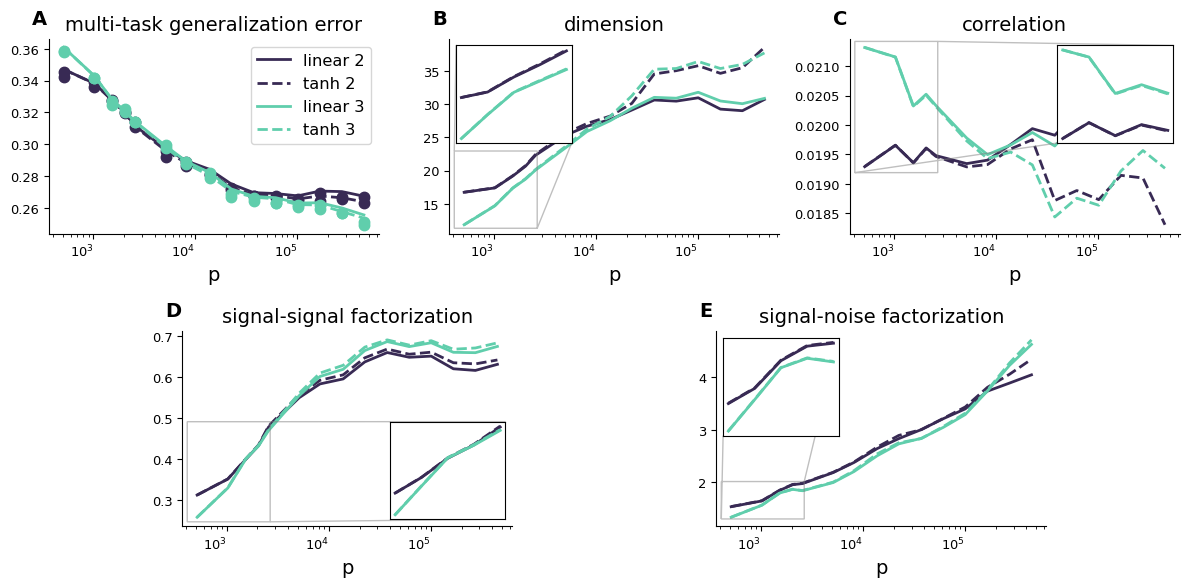

In [24]:
fig = plot_dynamics(res)
fig.savefig(figdir + '/sm_mlpdyn.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/mlpdyn.pdf')

In [16]:
# fig = plot_dynamics(res,show_early=True)
# fig.savefig(figdir + '/f5_mlpdyn_early.png', dpi=300, bbox_inches='tight')
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/mlpdyn.pdf')

## sup figs

In [25]:
def sm_fig(res, nonlin):
    rand_layer_names, errs_the_rand, errs_emp_rand, geoms_rand , \
    trained_layer_names, errs_the_train, errs_emp_train, geoms_train, \
    val_losses, train_losses, svm_rand, svm_train, \
    derrs_t, derrs_e, dgeoms, ps, dsvm = res.values() 
    fig = plt.figure(figsize=(12,8.5))
    gs = GridSpec(3,12)
    ax['a'] = fig.add_subplot(gs[0,1:5]) 
    ax['b'] = fig.add_subplot(gs[0,7:-1])

    ax['c'] = fig.add_subplot(gs[1,0:3])
    ax['d'] = fig.add_subplot(gs[1,3:6])
    ax['e'] = fig.add_subplot(gs[1,6:9])
    ax['f'] = fig.add_subplot(gs[1,9:])

    # ax['g'] = fig.add_subplot(gs[2,0])
    # ax['h'] = fig.add_subplot(gs[2,1])
    # ax['i'] = fig.add_subplot(gs[2,2])
    # ax['j'] = fig.add_subplot(gs[2,3])

    fn = 14
    tick_kwargs = {'rotation' : 45,
                   'ha' : 'right', 
                   'fontsize' : fn*0.8}

    cmap = plt.get_cmap('YlGnBu')([0.6,0.8])
    crand = cmap[0] 
    ctrain = cmap[1] 
    emkwargs = {'ls' : '', 'marker' : '^', 'markersize' : 6}
    space ='   '

    ax['a'].plot(rand_layer_names, errs_the_rand, label='theory', color=crand)
    ax['a'].errorbar(rand_layer_names, errs_emp_rand[:, 0], yerr=errs_emp_rand[:,1], label='empirical', color=crand, **emkwargs)
    ax['a'].set_xticklabels(rand_layer_names, **tick_kwargs)
    ax['a'].set_ylabel('$E_g$',fontsize=fn)
    # ax['a'].set_title(r'$\bf{A}$' + space + 'Random Network', fontsize=fn, loc='left') 
    ax['a'].set_title('random network', fontsize=fn) 

    ax['b'].plot(trained_layer_names, errs_the_train, label='theory', color=ctrain)
    ax['b'].errorbar(trained_layer_names, errs_emp_train[:, 0], yerr=errs_emp_train[:,1], label='empirical', color=ctrain, **emkwargs)
    # ax['c'].set_xlabel('Layer', fontsize=fn),
    ax['b'].set_xticklabels(trained_layer_names,**tick_kwargs)
    ax['b'].set_ylabel('$E_g$', fontsize=fn)
    # ax['b'].set_title(r'$\bf{B}$' +space +'Trained Network', fontsize=fn, loc='left')
    ax['b'].set_title('trained network', fontsize=fn)
    ax['b'].legend(fontsize=fn*3/4)

    names = ['dimension', 'correlation', 'signal-signal factorization', 'signal-noise factorization']
    axnames = ['c', 'd', 'e', 'f']

    # colors = ['salmon', 'slateblue', 'grey']
    ms=25
    # in the first two layers of the random net, H=0, so set it to inf to avoid numerical weirdness
    geoms_rand[:2, 3] = np.inf 
    for i, a in enumerate(axnames): 
        xtrain = np.linspace(0,1.,len(geoms_train[:,i]))
        xrand =  np.linspace(0,1.,len(geoms_rand[:,i]))
        ax[a].plot(xtrain, geoms_train[:, i], color=ctrain,  label='trained')
        ax[a].plot(xrand, geoms_rand[:, i], color=crand, label='random')
        for j, x in enumerate(trained_layer_names):
            if 'relu' in x or 'tanh' in x : 
                m = 's'
                ms = 40
                if j >= len(trained_layer_names) -2: 
                    if 'relu' in 'x': 
                        label = 'relu'
                    else:
                        label = 'tanh'
                else:
                    label = None 
            else:
                m = '.'
                ms = 90 
                if j >= len(trained_layer_names) -2: 
                    label = 'linear'
                else:
                    label = None
            ax[a].scatter(xtrain[j], geoms_train[j, i], color=ctrain, marker=m, s=ms, label=label)
        for j, x in enumerate(rand_layer_names):
            if 'relu' in x or 'tanh' in x : 
                m = 's'
                ms = 20
            else:
                m = '.'
                ms = 50 
            ax[a].scatter(xrand[j], geoms_rand[j, i], color=crand, marker=m, s=ms)
        ax[a].set_xticklabels([])
        # ax[a].set_ylabel(names[i], fontsize=fn)
        ax[a].set_title(names[i], fontsize=fn)
        ax[a].set_xlabel('fractional depth', fontsize=fn)
        # ax[a].set_title(axlabels[i], loc='left', fontsize=fn, weight='bold')
    ax['e'].legend(fontsize=fn*3/4, loc='lower right')

    axlabels = ['A', 'B', 'C', 'D', 'E', 'F'] 
    for i, a in enumerate(['a', 'b'] + axnames): 
        ax[a].text(-0.2, 1.2, axlabels[i], transform=ax[a].transAxes, 
            fontsize=fn, fontweight='bold', color='black', ha='left', va='top')


    plt.tight_layout(h_pad=.7)#h_pad=4., w_pad=3.)
    return fig

/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/4226557516.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['a'].set_xticklabels(rand_layer_names, **tick_kwargs)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/4226557516.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['b'].set_xticklabels(trained_layer_names,**tick_kwargs)


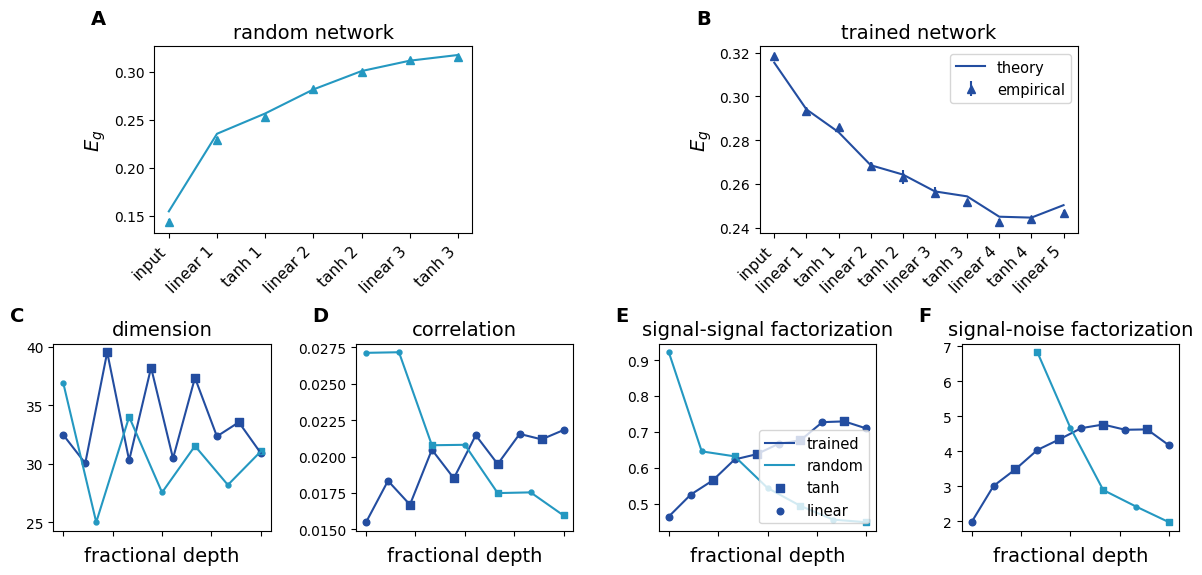

In [26]:
outpath = outdir + '/mlp_exps_P_500000_nonlin_tanh_alpha_0.2'
res = np.load(outpath + '/eg_geom_results.npy', allow_pickle=True).item()
fig = sm_fig(res,'tanh')
fig.savefig(figdir + '/sm_mlp_tanh.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/mlp_tanh.pdf')

G shape =  (15, 10, 5)
[  512  1024  1536  2048  2560  5120  8192 13824 22528 37376]
[   512   1024   1536   2048   2560   5120   8192  13824  22528  37376
  61440 100864 166400 273408 449536]


/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=0, ha='right',fontsize=fn*2/3)
/var/folders/gp/lnv6ly355f1_fgrk6jq0v2840000gq/T/ipykernel_60084/1511544480.py:72: UserWarning: set_

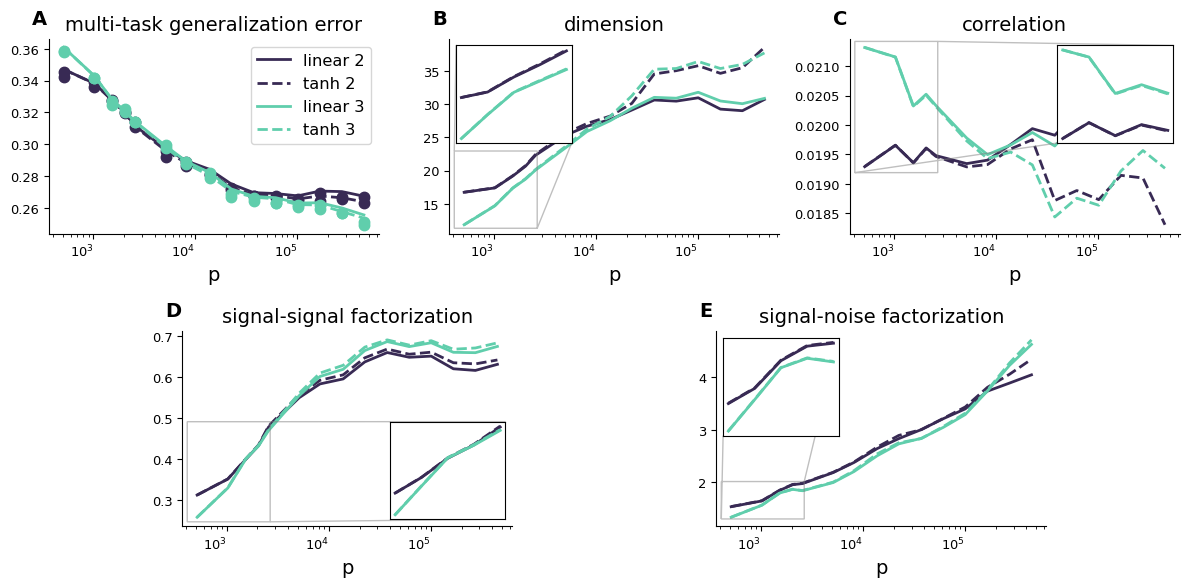

In [27]:
fig = plot_dynamics(res) 
fig.savefig(figdir + '/sm_mlpdyn_tanh.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/mlpdyn_tanh.pdf')

In [ ]:
# fig = plot_dynamics(res, show_early=True) 
# fig.savefig(figdir + '/sm_mlpdyn_tanh.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_1477826/4226557516.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['a'].set_xticklabels(rand_layer_names, **tick_kwargs)
/tmp/ipykernel_1477826/4226557516.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['b'].set_xticklabels(trained_layer_names,**tick_kwargs)


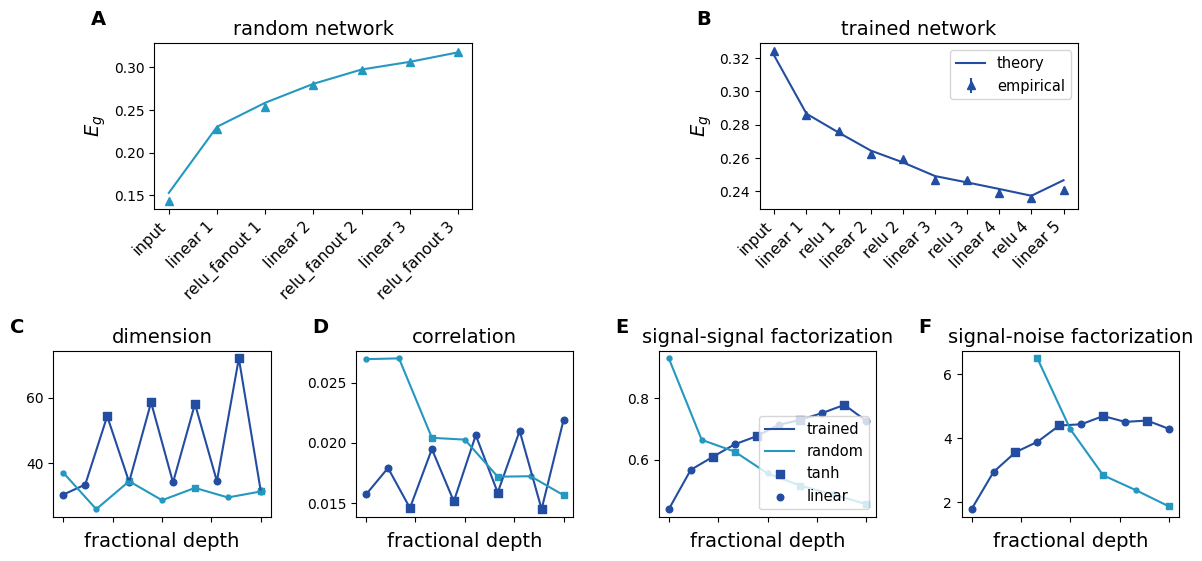

In [ ]:
outpath = outdir + '/mlp_exps_P_500000_nonlin_relu_fanout_alpha_0.2'
res = np.load(outpath + '/eg_geom_results.npy', allow_pickle=True).item()
fig = sm_fig(res,'tanh')
fig.savefig(figdir + '/sm_mlp_fanout.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('/mnt/home/awakhloo/ceph/abstraction/figs/mlp_tanh.pdf')